<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_I/blob/main/Atividade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalando as bibliotecas necessárias

from IPython.display import clear_output
!pip uninstall scipy -y
!pip install scipy

clear_output()

In [2]:
# importando as bibliotecas necessárias

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# lendo o DataFrame

data = pd.read_csv('/content/drive/MyDrive/IDP/Dataset/mrw.csv')

data

,number,country,n,i,o,rgdpw60,rgdpw85,gdpgrowth,popgrowth,i_y,school
0,1,Algeria,1,1,0,2485.0,4371.0,4.8,2.6,24.1,4.5
1,2,Angola,1,0,0,1588.0,1171.0,0.8,2.1,5.8,1.8
2,3,Benin,1,0,0,1116.0,1071.0,2.2,2.4,10.8,1.8
3,4,Botswana,1,1,0,959.0,3671.0,8.6,3.2,28.3,2.9
4,5,Burkina Faso,1,0,0,529.0,857.0,2.9,0.9,12.7,0.4
...,...,...,...,...,...,...,...,...,...,...,...
116,117,Australia,1,1,1,8440.0,13409.0,3.8,2.0,31.5,9.8
117,118,Fiji,0,0,0,3634.0,NaN,4.2,NaN,20.6,8.1
118,119,Indonesia,1,1,0,879.0,2159.0,5.5,1.9,13.9,4.1
119,120,New Zealand,1,1,1,9523.0,12308.0,2.7,1.7,22.5,11.9


In [4]:
# descrevendo o DataFrame

data.describe(include='all')

,number,country,n,i,o,rgdpw60,rgdpw85,gdpgrowth,popgrowth,i_y,school
count,121.000000,121,121.000000,121.000000,121.000000,116.000000,108.000000,117.000000,107.000000,121.000000,118.000000
unique,NaN,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Trinidad and Tobago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,61.000000,NaN,0.809917,0.619835,0.181818,3681.818966,5683.259259,4.094017,2.279439,18.157025,5.526271
std,35.073732,NaN,0.393998,0.487446,0.387298,7492.877637,5688.670819,1.891464,0.998748,7.853310,3.532037
min,1.000000,NaN,0.000000,0.000000,0.000000,383.000000,412.000000,-0.900000,0.300000,4.100000,0.400000
25%,31.000000,NaN,1.000000,0.000000,0.000000,973.250000,1209.250000,2.800000,1.700000,12.000000,2.400000
50%,61.000000,NaN,1.000000,1.000000,0.000000,1962.000000,3484.500000,3.900000,2.400000,17.700000,4.950000
75%,91.000000,NaN,1.000000,1.000000,0.000000,4274.500000,7718.750000,5.300000,2.900000,24.100000,8.175000


In [5]:
# retirando o número dos países

data.drop(["number"], axis=1, inplace=True)

# colocando país como index

data.set_index('country', inplace=True)

In [6]:
# Criando outras variáveis

data['lngd'] = np.log(data['popgrowth'] / 100 + 0.02 + 0.03)

# log da taxa de investimento

data['ls'] = np.log(data['i_y'] / 100)

# constante

data['const'] = 1

# log investimento - Log ∑(taxas)

data['ls_lngd'] = data['ls'] - data['lngd']

In [7]:
# criando mais variáveis logaritmizadas

# log da proxy de capital humano

data['lschool'] = np.log(data['school'] / 100)

# diferença dos logs de capital humano e (n + g +d)

data['lschool_lngd'] = data['lschool'] - data['lngd']

# log dos PIBs por pessoas em idade ativa em cada ano

data['ly60'] = np.log(data['rgdpw60'])
data['ly85'] = np.log(data['rgdpw85'])
data['linv'] = np.log(data['i_y'])

# criando variável de taxa de crescimento (≈ diferença dos logs)

data["taxa_crescimento"] = data["ly85"] - data["ly60"]

In [8]:
# criando DataFrames diferentes para cada grupo de países

# países sem dominância de petróleo

data_sem_petroleo = data.query("n == 1")

# com menos de 1 milhão de habitantes em 1960

data_baixa_pop = data.query("i == 1")

# OCDE

data_ocde = data.query("o == 1")

In [9]:
# Regressões

# definindo fórmula

formula = "ly85 ~ ls + lngd"

# países sem petróleo

reg1 = ols(formula=formula, data=data_sem_petroleo).fit()

# países com baixa população

reg2 = ols(formula=formula, data=data_baixa_pop).fit()

# países da OCDE

reg3 = ols(formula=formula, data=data_ocde).fit()

In [10]:
# criando tabela com o resultado dos três modelos

# criando um dicionário com os resultados que queremos que apareça

info_dict = {'R^2': lambda x: x.rsquared,
            'N': lambda x: x.nobs,
            "P-valor F": lambda x: x.f_pvalue}

resultados_iniciais = summary_col(results = [reg1, reg2, reg3],
                                  float_format='%0.3f',
                                  stars = True,
                                  model_names = ['Sem Petróleo',
                                                'Baixa População',
                                                'OCDE'],
                                  info_dict = info_dict,
                                  regressor_order=["ls", "lngd", "Intercept"])

print(resultados_iniciais)


          Sem Petróleo Baixa População   OCDE  
-----------------------------------------------
ls        1.424***     1.318***        0.500   
          (0.143)      (0.171)         (0.434) 
lngd      -1.990***    -2.017***       -0.742  
          (0.563)      (0.534)         (0.852) 
Intercept 5.430***     5.346***        8.021***
          (1.584)      (1.543)         (2.518) 
R^2       0.6009       0.5989          0.1059  
N         98.0000      75.0000         22.0000 
P-valor F 0.0000       0.0000          0.3452  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [11]:
# para impor a restrição de igualdade de coeficientes (βls =-βlngd), juntamos

# ls - lngd em uma só variável: ls_lngd, que já criamos

# definindo formula

formula = "ly85 ~ ls_lngd"

# países sem petróleo

regr1 = ols(formula=formula, data=data_sem_petroleo).fit()

# países com baixa população

regr2 = ols(formula=formula, data=data_baixa_pop).fit()

# países da OCDE

regr3 = ols(formula=formula, data=data_ocde).fit()

In [12]:
# criando tabela com o resultado dos três modelos

# note que esse coeficiente deve ser igual a α / (1- α), de forma que podemos,

# implicitamente, calcular a participação do capital no produto

info_dict1 = {'R^2': lambda x: x.rsquared,
            'N': lambda x: x.nobs,
            "P-valor F": lambda x: x.f_pvalue,
            "α Implícito": lambda x: f"{np.around(x.params[1]/(1 + x.params[1]), 2)}"}

resultados_iniciais1 = summary_col(results = [regr1, regr2, regr3],
                                  float_format='%0.3f',
                                  stars = True,
                                  model_names = ['Sem Petróleo',
                                                'Baixa População',
                                                'OCDE'],
                                  info_dict = info_dict1,
                                  regressor_order=["ls_lngd", "Intercept"])

print(resultados_iniciais1)


            Sem Petróleo Baixa População   OCDE  
-------------------------------------------------
ls_lngd     1.488***     1.431***        0.554   
            (0.125)      (0.139)         (0.365) 
Intercept   6.872***     7.093***        8.624***
            (0.121)      (0.146)         (0.533) 
R^2         0.5974       0.5917          0.1031  
N           98.0000      75.0000         22.0000 
P-valor F   0.0000       0.0000          0.1451  
α Implícito 0.6          0.59            0.36    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


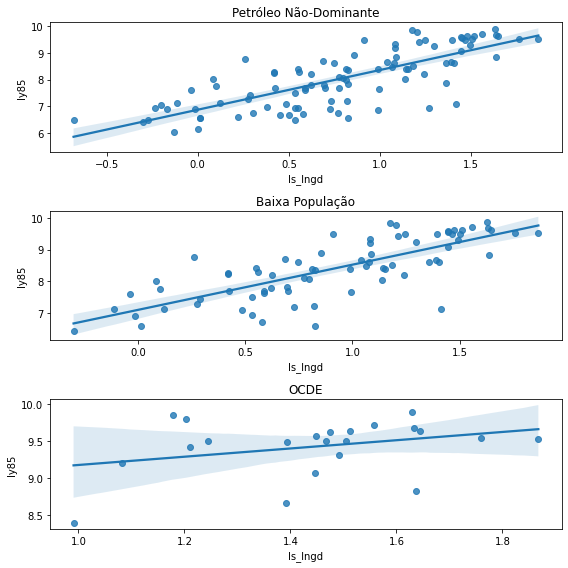

In [13]:
# podemos ver os resultados graficamente usando o lm do seaborn

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

# países onde o petróleo não é a indústria dominante

ax0 = sns.regplot(x="ls_lngd", y="ly85", data=data_sem_petroleo, ax=ax[0])
ax0.title.set_text("Petróleo Não-Dominante")

# países com baixa população

ax1 = sns.regplot(x="ls_lngd", y="ly85", data=data_baixa_pop, ax=ax[1])
ax1.title.set_text("Baixa População")

# países da OCDE

ax2 = sns.regplot(x="ls_lngd", y="ly85", data=data_ocde, ax=ax[2])
ax2.title.set_text("OCDE")

plt.tight_layout()
plt.show()

In [14]:
# definindo formula sem restrições (primeira equação da Teoria)

formula_aumentada = "ly85 ~ ls + lngd + lschool"

# países sem petróleo

regh1 = ols(formula=formula_aumentada, data=data_sem_petroleo).fit()

# países com baixa população

regh2 = ols(formula=formula_aumentada, data=data_baixa_pop).fit()

# países da OCDE

regh3 = ols(formula=formula_aumentada, data=data_ocde).fit()

In [15]:
# printando os três modelos

resultados_aumentados = summary_col(results = [regh1, regh2, regh3],
                                    float_format='%0.3f',
                                    stars = True,
                                    model_names = ['Sem Petróleo',
                                                  'Baixa População',
                                                  'OCDE'],
                                    info_dict = info_dict,
                                    regressor_order=["ls", "lngd", "lschool", "Intercept"])
print(resultados_aumentados)


          Sem Petróleo Baixa População   OCDE  
-----------------------------------------------
ls        0.697***     0.700***        0.276   
          (0.133)      (0.151)         (0.389) 
lngd      -1.745***    -1.500***       -1.076  
          (0.416)      (0.403)         (0.756) 
lschool   0.654***     0.731***        0.768** 
          (0.073)      (0.095)         (0.293) 
Intercept 6.844***     7.791***        8.637***
          (1.177)      (1.192)         (2.214) 
R^2       0.7856       0.7807          0.3524  
N         98.0000      75.0000         22.0000 
P-valor F 0.0000       0.0000          0.0455  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [16]:
# novamente, o coeficiente de lngd e ls devem ser iguais pelo modelo e iguais a α / (1-α)

# pelas equações acima, jávemos que eles são bem diferentes

# fórmula com restrição (segunda equação da Teoria)

formula_aumentada_restricao = "ly85 ~ ls_lngd + lschool_lngd"

# países sem petróleo

reghr1 = ols(formula=formula_aumentada_restricao, data=data_sem_petroleo).fit()

# países com baixa população

reghr2 = ols(formula=formula_aumentada_restricao, data=data_baixa_pop).fit()

# países da OCDE

reghr3 = ols(formula=formula_aumentada_restricao, data=data_ocde).fit()

In [17]:
# da mesma forma como fizemos antes, também podemos calcular os α e β implícitos pelos coeficientes

info_dict_aumentado = {'R^2': lambda x: x.rsquared_adj,
                      'N': lambda x: x.nobs,
                      "P-valor F": lambda x: x.f_pvalue,
                      'α Implícito': lambda x: f"{np.around(x.params[1]/(1 + x.params[1] + x.params[2]), 2)}",
                      'β Implícito': lambda x: f"{np.around(x.params[2]/(1 + x.params[1] + x.params[2]), 2)}"}

resultados_aumentados_restricao = summary_col(results = [reghr1, reghr2, reghr3],
                                              float_format='%0.3f',
                                              stars = True,
                                              model_names = ['Sem Petróleo',
                                                            'Baixa População',
                                                            'OCDE'],
                                              info_dict = info_dict_aumentado,
                                              regressor_order=["ls_lngd", "lschool_lngd", "Intercept"])
print(resultados_aumentados_restricao)


             Sem Petróleo Baixa População   OCDE  
--------------------------------------------------
ls_lngd      0.738***     0.709***        0.283   
             (0.124)      (0.138)         (0.334) 
lschool_lngd 0.657***     0.733***        0.769** 
             (0.073)      (0.093)         (0.284) 
Intercept    7.853***     7.966***        8.716***
             (0.140)      (0.154)         (0.466) 
R^2          0.7794       0.7745          0.2841  
N            98.0000      75.0000         22.0000 
P-valor F    0.0000       0.0000          0.0161  
α Implícito  0.31         0.29            0.14    
β Implícito  0.27         0.3             0.37    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [18]:
# vamos fazer três regressões para a primeira amostra de países (sem petróleo) com diferentes controles

# a ideia é: se há convergência, níveis maiores de renda em 1960 levariam a menores taxas médias de crescimento entre 1960 e 1985

# simples

regcon1 = ols(formula="taxa_crescimento ~ 1 + ly60", data=data_sem_petroleo).fit()

# controles

regcon2 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls", data=data_sem_petroleo).fit()

# controles + Capital Humano

regcon3 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls + lschool", data=data_sem_petroleo).fit()

In [19]:
# tabela com os resultados

resultados_iniciais_convergencia = summary_col(
    results = [regcon1, regcon2, regcon3],
    float_format='%0.3f',
    stars = True,
    model_names = ['Sem Petróleo',
                  'Baixa População',
                  'OCDE'],
    info_dict = info_dict,
    regressor_order=["ly60", "ls", "lngd", "lschool", "Intercept"]
)

print(resultados_iniciais_convergencia)


          Sem Petróleo Baixa População    OCDE  
------------------------------------------------
ly60      0.094*       -0.141***       -0.288***
          (0.050)      (0.052)         (0.062)  
ls                     0.647***        0.524*** 
                       (0.087)         (0.087)  
lngd                   -0.302          -0.506*  
                       (0.304)         (0.289)  
lschool                                0.231*** 
                                       (0.059)  
Intercept -0.267       1.919**         3.022*** 
          (0.380)      (0.834)         (0.827)  
R^2       0.0363       0.4019          0.4855   
N         98.0000      98.0000         98.0000  
P-valor F 0.0603       0.0000          0.0000   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [20]:
# Simples

regcon1 = ols(formula="taxa_crescimento ~ 1 + ly60", data=data_baixa_pop).fit()

# Controles

regcon2 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls", data=data_baixa_pop).fit()

# Controles + Capital Humano

regcon3 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls + lschool", data=data_baixa_pop).fit()

In [21]:
# tabela com os resultados - países com baixa população

resultados_iniciais_convergencia = summary_col(
    results = [regcon1, regcon2, regcon3],
    float_format='%0.3f',
    stars = True,
    model_names = ['Sem Petróleo',
                  'Baixa População',
                  'OCDE'],
    info_dict = info_dict,
    regressor_order=["ly60", "ls", "lngd", "lschool", "Intercept"]
)

print(resultados_iniciais_convergencia)

# na primeira regressão não há significância

# na segunda regressão o coeficiente ficou negativo e significativo - processo de convergência condicional

# também ocorre com mais força no grupo de países mais ricos


          Sem Petróleo Baixa População    OCDE  
------------------------------------------------
ly60      -0.004       -0.228***       -0.366***
          (0.055)      (0.057)         (0.067)  
ls                     0.646***        0.538*** 
                       (0.104)         (0.102)  
lngd                   -0.457          -0.545*  
                       (0.307)         (0.288)  
lschool                                0.270*** 
                                       (0.080)  
Intercept 0.588        2.250**         3.709*** 
          (0.433)      (0.855)         (0.909)  
R^2       0.0001       0.3788          0.4653   
N         75.0000      75.0000         75.0000  
P-valor F 0.9386       0.0000          0.0000   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [22]:
# Simples

regcon1 = ols(formula="taxa_crescimento ~ 1 + ly60", data=data_ocde).fit()

# Controles

regcon2 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls", data=data_ocde).fit()

# Controles + Capital Humano

regcon3 = ols(formula="taxa_crescimento ~ 1 + ly60 + lngd + ls + lschool", data=data_ocde).fit()

In [23]:
# tabela com os resultados - países OCDE

resultados_iniciais_convergencia = summary_col(
    results = [regcon1, regcon2, regcon3],
    float_format='%0.3f',
    stars = True,
    model_names = ['Sem Petróleo',
                  'Baixa População',
                  'OCDE'],
    info_dict = info_dict,
    regressor_order=["ly60", "ls", "lngd", "lschool", "Intercept"]
)

print(resultados_iniciais_convergencia)


          Sem Petróleo Baixa População    OCDE  
------------------------------------------------
ly60      -0.341***    -0.350***       -0.398***
          (0.079)      (0.066)         (0.070)  
ls                     0.390**         0.332*   
                       (0.176)         (0.173)  
lngd                   -0.766**        -0.863** 
                       (0.345)         (0.338)  
lschool                                0.228    
                                       (0.145)  
Intercept 3.686***     2.140*          2.755**  
          (0.685)      (1.181)         (1.201)  
R^2       0.4855       0.6767          0.7176   
N         22.0000      22.0000         22.0000  
P-valor F 0.0003       0.0001          0.0002   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [24]:
data = pd.read_stata('/content/drive/MyDrive/IDP/Dataset/pwt100.dta')

In [25]:
# vendo o DataFrame

data.head(10)

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ABW,Aruba,Aruban Guilder,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ABW,Aruba,Aruban Guilder,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ABW,Aruba,Aruban Guilder,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ABW,Aruba,Aruban Guilder,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ABW,Aruba,Aruban Guilder,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader

stata_reader = pd.read_stata('/content/drive/MyDrive/IDP/Dataset/pwt100.dta', iterator=True)

# Pegando as descrições das variáveis

descricoes = stata_reader.variable_labels()
descricoes

{'avh': 'Average annual hours worked by persons engaged (source: The Conference Board)',
 'ccon': 'Real consumption of households and government, at current PPPs (in mil. 2017US$)',
 'cda': 'Real domestic absorption, see note cda',
 'cgdpe': 'Expenditure-side real GDP at current PPPs (in mil. 2017US$)',
 'cgdpo': 'Output-side real GDP at current PPPs (in mil. 2017US$)',
 'ck': 'Capital services levels at current PPPs (USA=1)',
 'cn': 'Capital stock at current PPPs (in mil. 2017US$)',
 'cor_exp': 'Correlation between expenditure shares, see note cor_exp',
 'country': 'Country name',
 'countrycode': '3-letter ISO country code',
 'csh_c': 'Share of household consumption at current PPPs',
 'csh_g': 'Share of government consumption at current PPPs',
 'csh_i': 'Share of gross capital formation at current PPPs',
 'csh_m': 'Share of merchandise imports at current PPPs',
 'csh_r': 'Share of residual trade and GDP statistical discrepancy at current PPPs',
 'csh_x': 'Share of merchandise exports 

In [27]:
# definindo os anos

nAno1 = 1960
nAno2 = 1985

In [28]:
# Copiando o dataframe original com os dados entre 1960 e 1985

dataSolow = data.query(f"year >= {nAno1} & year <= {nAno2}").copy()

# Criando o PIB por trabalhador

dataSolow["rgdpo_emp"] = dataSolow["rgdpo"] / dataSolow['emp']

# E deixar apenas as variáveis de interesse

dataSolow = dataSolow[["country", "year", "rgdpo", "emp", "rgdpo_emp", "csh_i", "hc", "delta"]]

# Vendo o tamanho da base

print(f"Linhas: {dataSolow.shape[0]}; Colunas: {dataSolow.shape[1]}")

# Vendo uma amostra (sample) de 5 dados aleatórios

dataSolow.sample(n=5)

Linhas: 4758; Colunas: 8


,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta
6735,Lebanon,1965,NaN,NaN,NaN,NaN,NaN,NaN
1694,Brazil,1964,228095.031250,24.860933,9174.837891,0.167561,1.438548,0.050255
5837,Israel,1977,61854.101562,1.347610,45899.121094,0.247442,2.818282,0.033487
9752,Qatar,1972,14776.316406,0.056145,263179.968750,0.182083,1.584563,0.047390
8223,Mauritania,1983,6064.204102,0.423724,14311.696289,0.313194,1.291712,0.037196


In [29]:
# contando nans

for sVariavel in ["rgdpo", "emp", "csh_i", "hc", "delta"]:
  dataSolow[f"nans_{sVariavel}"] = dataSolow[f"{sVariavel}"].isnull().groupby(dataSolow["country"]).transform('sum')

# Vendo resultado

dataSolow

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,nans_rgdpo,nans_emp,nans_csh_i,nans_hc,nans_delta
10,Aruba,1960,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10
11,Aruba,1961,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10
12,Aruba,1962,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10
13,Aruba,1963,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10
14,Aruba,1964,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12771,Zimbabwe,1981,28192.455078,3.262573,8641.172852,0.164452,1.574376,0.034467,0,0,0,0,0
12772,Zimbabwe,1982,29824.212891,3.394048,8787.208984,0.130539,1.606587,0.035067,0,0,0,0,0
12773,Zimbabwe,1983,34796.503906,3.532258,9851.064453,0.078936,1.639457,0.035094,0,0,0,0,0
12774,Zimbabwe,1984,33214.589844,3.676033,9035.442383,0.088299,1.672999,0.034592,0,0,0,0,0


In [30]:
# somando nans

dataSolow["nans"] = np.sum(dataSolow[["nans_rgdpo", "nans_emp", "nans_csh_i", "nans_hc", "nans_delta"]], axis=1)
dataSolow

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,nans_rgdpo,nans_emp,nans_csh_i,nans_hc,nans_delta,nans
10,Aruba,1960,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10,82
11,Aruba,1961,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10,82
12,Aruba,1962,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10,82
13,Aruba,1963,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10,82
14,Aruba,1964,NaN,NaN,NaN,NaN,NaN,NaN,10,26,10,26,10,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12771,Zimbabwe,1981,28192.455078,3.262573,8641.172852,0.164452,1.574376,0.034467,0,0,0,0,0,0
12772,Zimbabwe,1982,29824.212891,3.394048,8787.208984,0.130539,1.606587,0.035067,0,0,0,0,0,0
12773,Zimbabwe,1983,34796.503906,3.532258,9851.064453,0.078936,1.639457,0.035094,0,0,0,0,0,0
12774,Zimbabwe,1984,33214.589844,3.676033,9035.442383,0.088299,1.672999,0.034592,0,0,0,0,0,0


In [31]:
# Retirando observações com ao menos 1 nan

dataSolow.query("nans == 0", inplace=True)

# Selecionando (novamente) apenas as colunas de interesse

# E deixar apenas as variáveis de interesse

dataSolow = dataSolow[["country", "year", "rgdpo", "emp", "rgdpo_emp", "csh_i", "hc", "delta"]].copy()

# Vendo o tamanho da base

print(f"Linhas: {dataSolow.shape[0]}; Colunas: {dataSolow.shape[1]}")

Linhas: 2340; Colunas: 8


In [32]:
# dataSolow["country"], e não apenas "country"

dataSolow[f"csh_i_media"] = dataSolow["csh_i"].groupby(dataSolow["country"]).transform('mean')
dataSolow[f"delta_media"] = dataSolow["delta"].groupby(dataSolow["country"]).transform('mean')
dataSolow[f"hc_media"] = dataSolow["hc"].groupby(dataSolow["country"]).transform('mean')

# Vendo resultado

dataSolow.head(25)

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media
360,Argentina,1960,65991.281250,7.642992,8634.220703,0.148988,1.953866,0.030305,0.141233,0.032384,2.14262
361,Argentina,1961,68127.414062,7.739992,8802.000000,0.151162,1.964928,0.031382,0.141233,0.032384,2.14262
362,Argentina,1962,69384.203125,7.838223,8852.032227,0.131594,1.976053,0.032225,0.141233,0.032384,2.14262
363,Argentina,1963,66981.187500,7.937701,8438.361328,0.113241,1.987240,0.032465,0.141233,0.032384,2.14262
364,Argentina,1964,70325.312500,8.038442,8748.625000,0.139779,1.998491,0.032569,0.141233,0.032384,2.14262
365,Argentina,1965,79025.890625,8.140460,9707.791992,0.128806,2.009806,0.032827,0.141233,0.032384,2.14262
366,Argentina,1966,80755.507812,8.240280,9800.092773,0.120990,2.022713,0.032946,0.141233,0.032384,2.14262
367,Argentina,1967,83494.257812,8.341325,10009.711914,0.119687,2.035703,0.032919,0.141233,0.032384,2.14262
368,Argentina,1968,85935.945312,8.443606,10177.634766,0.125976,2.048777,0.032843,0.141233,0.032384,2.14262
369,Argentina,1969,94348.562500,8.547144,11038.607422,0.142668,2.061934,0.032869,0.141233,0.032384,2.14262


In [33]:
# Agora que já calculamos as médias simples, podemos usar apenas os dados de 1960 e 1985

dataSolow9015 = dataSolow.query(f"year == {nAno1} | year == {nAno2}").copy()

In [34]:
# Criando a coluna de variação percentual do PIB e da população

dataSolow9015["cresc_rgdpo_medio"] = (dataSolow9015["rgdpo"].pct_change() + 1)**(1 / 25) - 1
dataSolow9015["cresc_emp_medio"] = (dataSolow9015["emp"].pct_change() + 1)**(1 / 25) - 1
dataSolow9015

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio
360,Argentina,1960,65991.281250,7.642992,8634.220703,0.148988,1.953866,0.030305,0.141233,0.032384,2.142620,NaN,NaN
385,Argentina,1985,149748.687500,10.633324,14082.961914,0.106565,2.420576,0.030510,0.141233,0.032384,2.142620,0.033321,0.013296
570,Australia,1960,165419.750000,4.155402,39808.359375,0.356183,2.746758,0.023457,0.307754,0.024277,3.030454,0.003989,-0.036886
595,Australia,1985,415789.562500,6.681815,62227.042969,0.304934,3.310743,0.024901,0.307754,0.024277,3.030454,0.037556,0.019181
640,Austria,1960,72448.734375,3.440428,21058.056641,0.215909,2.403941,0.035384,0.235574,0.036859,2.654884,-0.067505,-0.026202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12635,South Africa,1985,319723.625000,9.559117,33446.980469,0.183702,1.886944,0.044930,0.231525,0.041133,1.813832,0.041935,0.011615
12680,Zambia,1960,5879.212891,1.040616,5649.743164,0.053204,1.277846,0.032636,0.050909,0.038189,1.470275,-0.147721,-0.084887
12705,Zambia,1985,13693.442383,2.015025,6795.668945,0.019438,1.716415,0.040546,0.050909,0.038189,1.470275,0.034398,0.026785
12750,Zimbabwe,1960,9417.795898,1.732082,5437.268555,0.201060,1.242618,0.033241,0.157501,0.032350,1.432150,-0.014861,-0.006034


In [35]:
# Note que os valores que queremos estão em year == 1985

dataSolowFinal = dataSolow9015.query(f"year == {nAno2}").copy()

# Vendo resultado

dataSolowFinal

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio
385,Argentina,1985,1.497487e+05,10.633324,14082.961914,0.106565,2.420576,0.030510,0.141233,0.032384,2.142620,0.033321,0.013296
595,Australia,1985,4.157896e+05,6.681815,62227.042969,0.304934,3.310743,0.024901,0.307754,0.024277,3.030454,0.037556,0.019181
665,Austria,1985,1.587050e+05,3.431708,46246.664062,0.303010,2.877572,0.036106,0.235574,0.036859,2.654884,0.031864,-0.000102
875,Belgium,1985,1.997505e+05,3.648164,54753.714844,0.249281,2.663102,0.038224,0.288007,0.040377,2.435385,0.029376,0.001716
1015,Burkina Faso,1985,8.692414e+03,3.413159,2546.735840,0.212285,1.021879,0.041937,0.095419,0.040904,1.010960,0.022010,0.009259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12145,United States,1985,8.533360e+06,111.384384,76611.820312,0.279477,3.391358,0.034412,0.251746,0.033226,3.113626,0.036031,0.018200
12355,Venezuela (Bolivarian Republic of),1985,1.652271e+05,5.106100,32358.765625,0.223162,1.821983,0.040251,0.347972,0.039696,1.521766,0.040505,0.031596
12635,South Africa,1985,3.197236e+05,9.559117,33446.980469,0.183702,1.886944,0.044930,0.231525,0.041133,1.813832,0.041935,0.011615
12705,Zambia,1985,1.369344e+04,2.015025,6795.668945,0.019438,1.716415,0.040546,0.050909,0.038189,1.470275,0.034398,0.026785


In [36]:
# Criando outras variáveis

# Log da taxa de crescimento da população empregada (n) + taxa crescimento PIB (g) + depreciação anual (d)

# prefixo l: log!

dataSolowFinal['lngd'] = np.log(dataSolowFinal['cresc_emp_medio'] + dataSolowFinal['cresc_rgdpo_medio'] + dataSolowFinal['delta_media'])

# Log da taxa de investimento (poupança)

dataSolowFinal['ls'] = np.log(dataSolowFinal['csh_i_media'])

# Log investimento - Log ∑(taxas)

dataSolowFinal['ls_lngd'] = dataSolowFinal['ls'] - dataSolowFinal['lngd']

In [37]:
# Criando mais variáveis logaritmizadas

# Log da proxy de capital humano

dataSolowFinal['lschool'] = np.log(dataSolowFinal['hc_media'] / 100)

# Diferença dos logs de capital humano e (n + g +d)

dataSolowFinal['lschool_lngd'] = dataSolowFinal['lschool'] - dataSolowFinal['lngd']

# Log dos PIBs por pessoas em idade ativa

dataSolowFinal['ly'] = np.log(dataSolowFinal['rgdpo'])

dataSolowFinal

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio,lngd,ls,ls_lngd,lschool,lschool_lngd,ly
385,Argentina,1985,1.497487e+05,10.633324,14082.961914,0.106565,2.420576,0.030510,0.141233,0.032384,2.142620,0.033321,0.013296,-2.538306,-1.957345,0.580960,-3.843141,-1.304836,11.916714
595,Australia,1985,4.157896e+05,6.681815,62227.042969,0.304934,3.310743,0.024901,0.307754,0.024277,3.030454,0.037556,0.019181,-2.513136,-1.178454,1.334683,-3.496458,-0.983321,12.937935
665,Austria,1985,1.587050e+05,3.431708,46246.664062,0.303010,2.877572,0.036106,0.235574,0.036859,2.654884,0.031864,-0.000102,-2.679157,-1.445731,1.233427,-3.628769,-0.949612,11.974803
875,Belgium,1985,1.997505e+05,3.648164,54753.714844,0.249281,2.663102,0.038224,0.288007,0.040377,2.435385,0.029376,0.001716,-2.638487,-1.244769,1.393718,-3.715065,-1.076578,12.204824
1015,Burkina Faso,1985,8.692414e+03,3.413159,2546.735840,0.212285,1.021879,0.041937,0.095419,0.040904,1.010960,0.022010,0.009259,-2.628685,-2.349476,0.279209,-4.594270,-1.965585,9.070206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12145,United States,1985,8.533360e+06,111.384384,76611.820312,0.279477,3.391358,0.034412,0.251746,0.033226,3.113626,0.036031,0.018200,-2.436608,-1.379334,1.057274,-3.469382,-1.032774,15.959494
12355,Venezuela (Bolivarian Republic of),1985,1.652271e+05,5.106100,32358.765625,0.223162,1.821983,0.040251,0.347972,0.039696,1.521766,0.040505,0.031596,-2.191062,-1.055634,1.135428,-4.185299,-1.994237,12.015076
12635,South Africa,1985,3.197236e+05,9.559117,33446.980469,0.183702,1.886944,0.044930,0.231525,0.041133,1.813832,0.041935,0.011615,-2.357219,-1.463067,0.894152,-4.009728,-1.652509,12.675212
12705,Zambia,1985,1.369344e+04,2.015025,6795.668945,0.019438,1.716415,0.040546,0.050909,0.038189,1.470275,0.034398,0.026785,-2.308877,-2.977712,-0.668834,-4.219721,-1.910843,9.524673


In [38]:
# Definindo formula

formula_trad_irrestrito = "ly ~ ls + lngd"

# Modelo

mod_trad_irrestrito = ols(formula=formula_trad_irrestrito, data=dataSolowFinal).fit()

# Sumário

print(mod_trad_irrestrito.summary())

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     5.416
Date:                Fri, 10 Dec 2021   Prob (F-statistic):            0.00607
Time:                        02:10:16   Log-Likelihood:                -171.02
No. Observations:                  90   AIC:                             348.0
Df Residuals:                      87   BIC:                             355.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9226      1.373      8.685      0.0

In [39]:
# Definindo formula

formula_trad_restrito = "ly ~ ls_lngd"

# Modelo

mod_trad_restrito = ols(formula=formula_trad_restrito, data=dataSolowFinal).fit()

# Sumário

print(mod_trad_restrito.summary())

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     10.08
Date:                Fri, 10 Dec 2021   Prob (F-statistic):            0.00207
Time:                        02:10:43   Log-Likelihood:                -171.43
No. Observations:                  90   AIC:                             346.9
Df Residuals:                      88   BIC:                             351.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7276      0.234     45.829      0.0

In [40]:
# Calculando α (participação do capital) implícita

print(f"α Implícito: {np.around(mod_trad_restrito.params[1]/(1 + mod_trad_restrito.params[1]), 2)}")

α Implícito: 0.45


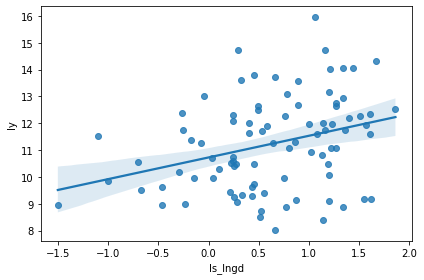

In [41]:
# Podemos ver os resultados graficamente usando o lm do seaborn

sns.regplot(x="ls_lngd", y="ly", data=dataSolowFinal)

plt.tight_layout()
plt.show()

In [42]:
# Modelo irrestrito

# Definindo formula

formula_aumentado_irrestrito = "ly~ ls + lngd + lschool"

# Modelo

mod_aumentado_irrestrito = ols(formula=formula_aumentado_irrestrito, data=dataSolowFinal).fit()

# Sumário

print(mod_aumentado_irrestrito.summary())

# Capital Humano parece dominar os efeitos do capital físico, que se torna insignifcante

# Apesar de ser insignificante, o sinal de lngd vai contra a teoria

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.675
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           0.000419
Time:                        02:11:35   Log-Likelihood:                -166.88
No. Observations:                  90   AIC:                             341.8
Df Residuals:                      86   BIC:                             351.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.1283      3.141      6.409      0.0

In [43]:
# Modelo com igualdade de coeficientes

# Definindo formula

formula_aumentado_restrito = "ly ~ ls_lngd + lschool_lngd"

# Modelo

mod_aumentado_restrito = ols(formula=formula_aumentado_restrito, data=dataSolowFinal).fit()

# Sumário

print(mod_aumentado_restrito.summary())

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     5.722
Date:                Fri, 10 Dec 2021   Prob (F-statistic):            0.00463
Time:                        02:12:02   Log-Likelihood:                -170.74
No. Observations:                  90   AIC:                             347.5
Df Residuals:                      87   BIC:                             355.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.7954      0.955     12.352   

In [44]:
# Calculando α (participação do capital físico) implícita

print(f"α Implícito: {np.around(mod_aumentado_restrito.params[1]/(1 + mod_aumentado_restrito.params[1] + mod_aumentado_restrito.params[2]), 2)}")

# Calculando β (participação do capital humano) implícita

print(f"β Implícito: {np.around(mod_aumentado_restrito.params[2]/(1 + mod_aumentado_restrito.params[1] + mod_aumentado_restrito.params[2]), 2)}")

α Implícito: 0.27
β Implícito: 0.25
